In [94]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [95]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
User cancelled operation


In [178]:
import zipfile
zip_ref = zipfile.ZipFile('/content/microsoft-catsvsdogs-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [179]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [180]:
input_path = []
labels = []

for class_ in os.listdir('PetImages'):
  for path in os.listdir(f'PetImages/{class_}'):
    if class_== "Cat":
      labels.append(0)
    else:
      labels.append(1)
    input_path.append(f'PetImages/{class_}/{path}')

print(input_path[1],labels[1])

PetImages/Cat/1774.jpg 0


In [181]:
df = pd.DataFrame()
df['images'] = input_path
df['labels'] = labels
df = df.sample(frac = 1).reset_index(drop = True)
df.head()

,images,labels
0,PetImages/Dog/6147.jpg,1
1,PetImages/Cat/6578.jpg,0
2,PetImages/Dog/5010.jpg,1
3,PetImages/Cat/11514.jpg,0
4,PetImages/Cat/4992.jpg,0


In [184]:
for i in df['images']:
  if '.jpg' not in i:
    print(i)

In [183]:
df= df[df['images']!= 'PetImages/Dog/Thumbs.db']
df= df[df['images']!= 'PetImages/Cat/Thumbs.db']
len(df)

25000

In [185]:
from PIL import Image
corrupted_files = []

for f in df['images']:
    try:
        img = Image.open(f)
        img.verify()
    except:
        corrupted_files.append(f)

# Remove corrupted files
df = df[~df['images'].isin(corrupted_files)].reset_index(drop=True)

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


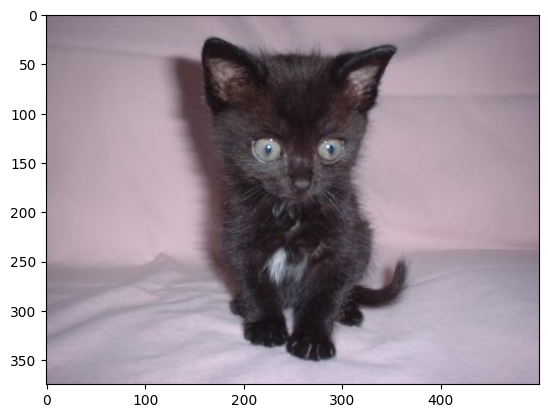

In [186]:
img_path = df['images'].iloc[3]  # e.g., 'PetImages/Cat/1.png'

# Read the image
img = mpimg.imread(img_path)
plt.imshow(img)

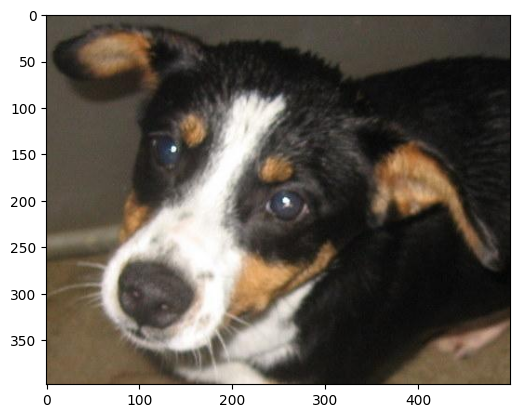

In [187]:
dog_rows = df[df['labels'] == 1]  # assuming df['labels'] contains 0 = Cat, 1 = Dog

# Pick first dog image
img_path = dog_rows['images'].iloc[0]

# Read the image
img = mpimg.imread(img_path)
plt.imshow(img)

In [188]:
len(df)

24998

In [191]:
df['labels'] = df['labels'].astype('str')
df.head()

,images,labels
0,PetImages/Dog/6147.jpg,1
1,PetImages/Cat/6578.jpg,0
2,PetImages/Dog/5010.jpg,1
3,PetImages/Cat/11514.jpg,0
4,PetImages/Cat/4992.jpg,0


In [192]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [194]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import path
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='labels',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='labels',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [198]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [199]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [200]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.5045 - loss: 0.9488 - val_accuracy: 0.5624 - val_loss: 0.6785
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.5807 - loss: 0.6734 - val_accuracy: 0.6498 - val_loss: 0.6277
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.6574 - loss: 0.6149 - val_accuracy: 0.6684 - val_loss: 0.6034
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.6811 - loss: 0.5890 - val_accuracy: 0.7320 - val_loss: 0.5400
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.7194 - loss: 0.5488 - val_accuracy: 0.7346 - val_loss: 0.5326
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.7294 - loss: 0.5340 - val_accuracy: 0.7458 - val_loss: 0.5081
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7364 - loss: 0.5222 - val_accuracy: 0.7692 - val_loss: 0.4876
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7584 - loss: 0.4948 - val_accuracy: 0.7612 - v

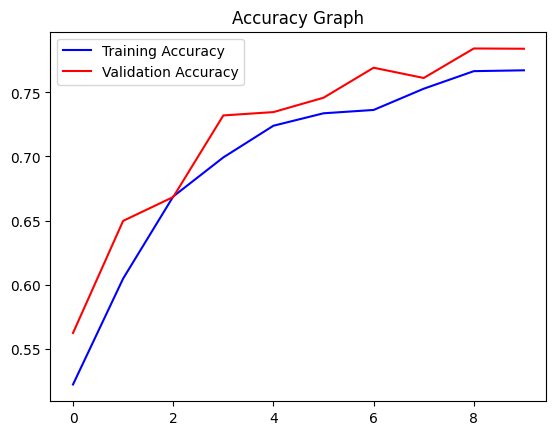

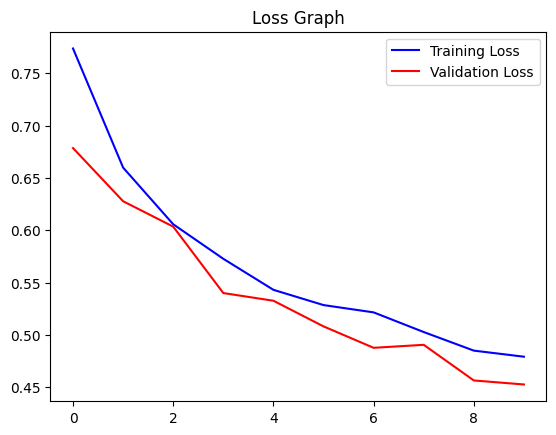

In [201]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: PetImages/Dog/4399.jpg
True Label: 1
Predicted Probability (Dog): 0.7060
Predicted Label: Dog
Prediction is Correct: True


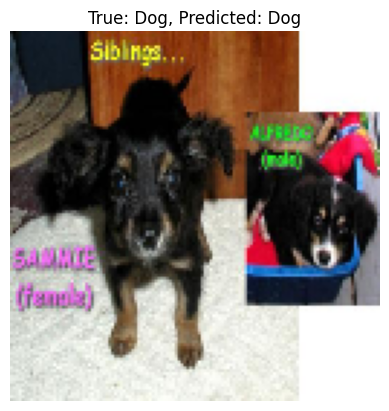

In [207]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt # Import matplotlib

# Function to test a single image
def test_single_image(image_path, true_label):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128, 128)) # Use the same target size as training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    img_array /= 255.0 # Rescale the image

    # Make prediction
    prediction_prob = model.predict(img_array)[0][0]
    predicted_label = 1 if prediction_prob > 0.5 else 0

    print(f"Image: {image_path}")
    print(f"True Label: {true_label}")
    print(f"Predicted Probability (Dog): {prediction_prob:.4f}")
    print(f"Predicted Label: {'Dog' if predicted_label == 1 else 'Cat'}")
    print(f"Prediction is Correct: {predicted_label == true_label}")

    # Display the image
    plt.imshow(img)
    plt.title(f"True: {'Dog' if true_label == 1 else 'Cat'}, Predicted: {'Dog' if predicted_label == 1 else 'Cat'}")
    plt.axis('off')
    plt.show()


# Example usage:
# Replace with the path to an image from your test set and its true label
# You can get a sample image path from the 'test' dataframe
sample_image_path = test['images'].iloc[0]
sample_true_label = int(test['labels'].iloc[0]) # Convert string label to int

test_single_image(sample_image_path, sample_true_label)